In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import multiprocessing

def cllct_rslts(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.extend(result)
def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)


#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [16]:
TotalFrame.sort_values('PC1').cell

3977    20230524_488EGFP-CAAX_640SPY650-DNA4_cell_30_f...
2049    20230510_488EGFP-CAAX_640JF646actin-halotag6_c...
3125    20230524_488EGFP-CAAX_640SPY650-DNA1_cell_24_f...
2034    20230510_488EGFP-CAAX_640JF646actin-halotag6_c...
2037    20230510_488EGFP-CAAX_640JF646actin-halotag6_c...
                              ...                        
4374    20230524_488EGFP-CAAX_640SPY650-DNA5_cell_30_f...
4372    20230524_488EGFP-CAAX_640SPY650-DNA5_cell_30_f...
9403    20230802_488EGFP-CAAX_640actin-halotag_Galv6_c...
9409    20230802_488EGFP-CAAX_640actin-halotag_Galv6_c...
9956    20230802_488EGFP-CAAX_640actin-halotag_Random3...
Name: cell, Length: 10643, dtype: object

In [5]:
#get directories and open separated datasets

savedir = 'D:/Aaron/Data/Chem_Galv_Combined/Data_and_Figs/'


if os.path.exists(savedir + 'Shape_Metrics_transitionPCbins.csv'):
    
    TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)
    print('Opened binned PCs')
    
    #still need to calculate PC bins for later plots
    nbins = 11
    hist1, PC1bins = np.histogram(TotalFrame.PC1, nbins)
    hist2, PC2bins = np.histogram(TotalFrame.PC2, nbins)
    hist3, PC3bins = np.histogram(TotalFrame.PC3, nbins)
    hist4, PC4bins = np.histogram(TotalFrame.PC4, nbins)
    
else:
    from CustomFunctions import shapePCAtools
    from vtk.util import numpy_support
    import vtk
    from aicsshparam import shtools
    import pickle as pk
    
    
    #get directories
    gfl = 'D:/Aaron/Data/Galvanotaxis/'
    gfolder_fl = gfl + 'Data_and_Figs/'

    cfl = 'D:/Aaron/Data/Chemotaxis/'
    cfolder_fl = cfl + 'Data_and_Figs/'
    #open the separate files
    Chem_Shape_Metrics = pd.read_csv(cfolder_fl + 'Shape_Metrics_outliersremoved.csv', index_col=0)
    Galv_Shape_Metrics = pd.read_csv(gfolder_fl + 'Shape_Metrics_outliersremoved.csv', index_col=0)
    
    #combine the two datasets
    TotalFrame = pd.concat([Chem_Shape_Metrics, Galv_Shape_Metrics]).reset_index(drop=True)
    
    #add a column that identifies cells across all frames
    TotalFrame = TotalFrame.rename(columns={"cell.1": "cell"})
    TotalFrame['CellID'] = [x.split('_frame')[0] for x in TotalFrame.cell.to_list()]
    
    #add tags for different experiments
    galvdates = ['20230727',
           '20230801',
           '20230802',
           '20230803']
    exp = []
    for e in TotalFrame.CellID.to_list():
        truth = [True for g in galvdates if g in e]
        if any(truth):
            exp.append('Galv')
        else:
            exp.append('Chem')
    TotalFrame['Experiment'] = exp
    

    ################# Generate new PCs ##############
    from sklearn.decomposition import PCA

    #specify number of PCs and number of bins
    npcs = 10
    nbins = 5
    bins = list(range(1,nbins+1))
    lmax = 10


    shcoeffs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'shcoeffs' in x]].reset_index(drop=True)

    # Fit and transform the data
    pca = PCA(n_components=npcs)
    pca = pca.fit(shcoeffs)
    matrix_of_features_transform = pca.transform(shcoeffs)

    # Dataframe of transformed variable
    pc_names = [f"PC{c}" for c in range(1, 1 + npcs)]
    df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = TotalFrame.index)
    #drop the previous PCs and 
    TotalFrame = TotalFrame.merge(df_trans, left_index = True, right_index = True)

    # Adjust the sign of PCs so that larger cells are represent by positive values
    for pcid, pc_name in enumerate(pc_names):
        pearson = np.corrcoef(TotalFrame.Cell_Volume.values, TotalFrame[pc_name].values)
        if pearson[0, 1] < 0:
            TotalFrame[pc_name] *= -1
            pca.components_[pcid] *= -1


    ################ RECONSTRUCT CELLS AT CERTAIN POINTS IN THE "SHAPE SPACE" ##################

    df_dig = pd.DataFrame(index = df_trans.index)
    for count, col in enumerate(df_trans.columns.to_list()):
        df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
            df = df_trans,
            feature = col,
            nbins = nbins,
            filter_based_on = df_trans.columns.to_list(),
            filter_extremes_pct = float(1),
            save = None,
            return_freqs_per_structs = False
        )
        #put bin_indexes into a larger list that I can later iterate through
        df_dig = df_dig.merge(df_digit[[col,'bin']], left_index = True, right_index = True)
        df_dig = df_dig.rename(columns={'bin':f'PC{count+1}_bins'})


    mid = math.ceil(nbins/2)
    recon_PCs = np.zeros((npcs, nbins, npcs))
    for pi, p in enumerate(pc_names):
        for c in range(nbins):
            for ni, n in enumerate(pc_names):
                if n == p:
                    recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==c+1].loc[:,n].mean()
                else:
                    recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==mid].loc[:,n].mean()

    #get inverse pca transform of those values
    recon_schoeffs = np.zeros((npcs, nbins, len(shcoeffs.columns)))
    for o in range(recon_schoeffs.shape[0]):
        for t in range(recon_schoeffs.shape[1]):
                recon_schoeffs[o,t,:] = pca.inverse_transform(recon_PCs[o,t,:])


    #combine metrics and digitized pcs
    df_dig = TotalFrame.merge(df_dig, left_index = True, right_index = True)
    #save
    df_dig.to_csv(savedir+"Shape_Metrics_with_Digitized_PCs.csv")


    ########### GET RECONSTRUCTIONS OF AVERAGE CELLS FROM SHAPE SPACE BINS ##########################

    meshes = {}
    for pi, p in enumerate(pc_names):
        meshes[p] = {}
        for c in range(nbins):
            meshes[p][bins[c]] = {}
            mesh, _ = shtools.get_reconstruction_from_coeffs(recon_schoeffs[pi,c,:].reshape(2,lmax+1,lmax+1))
            meshes[p][bins[c]] = mesh



    ################## save PC meshes ##################
    pcmeshdir = savedir + 'PC_Meshes/'
    if not os.path.exists(pcmeshdir):
        os.makedirs(pcmeshdir)
    for p in list(meshes):
        for n, b in enumerate(list(meshes[p])):
            writer = vtk.vtkXMLPolyDataWriter()
            writer.SetFileName(pcmeshdir+p+'_'+str(b)+'_'+'.vtp')
            writer.SetInputData(meshes[p][b])
            writer.Write()

    ####### also save the pca object for later use ###########
    pk.dump(pca, open(savedir+"pca.pkl","wb"))


    ########### plot distributions of PCs ###################
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
    for i, ax in enumerate(axes[:]):
        ax.hist(df_trans.iloc[:,i].values, 30)
    # for i, ax in enumerate(axes[:,1]):
    #     ax.hist(nuc_weights[:,i], 30, (-2,2))

    axes[0].set_title("PC Distributions", fontsize = 20)
    # axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
    [ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
    axes[7].set_xlabel("Component value")

    plt.tight_layout()
    plt.savefig(savedir + 'PC distributions.png', bbox_inches='tight')



    # How much variance is explained?
    cell_variance = np.cumsum(pca.explained_variance_ratio_)
    component_number = np.arange(len(cell_variance)) + 1

    # Analysis of explained variance
    df_dimred = {}
    loading = pca.components_.T * np.sqrt(pca.explained_variance_)
    for comp, pc_name in enumerate(pc_names):
        load = loading[:, comp]
        pc = [v for v in load]
        apc = [v for v in np.abs(load)]
        total = np.sum(apc)
        cpc = [100 * v / total for v in apc]
        df_dimred[pc_name] = pc
        df_dimred[pc_name.replace("_PC", "_aPC")] = apc
        df_dimred[pc_name.replace("_PC", "_cPC")] = cpc

    # Store results as a dataframe
    df_dimred["features"] = shcoeffs.columns
    df_dimred = pd.DataFrame(df_dimred)
    df_dimred = df_dimred.set_index("features", drop=True)

    # Plot variance
    plt.figure(figsize=(4, 3))
    plt.plot(component_number, cell_variance)
    plt.ylim(0,1)
    plt.xlabel("n-components")
    plt.ylabel("Explained variance")
    plt.title("Fraction of variance captured")

    plt.tight_layout()
    plt.savefig(savedir + 'Variance captured.png', bbox_inches='tight')





    ############## SEE WHICH FEATURES ARE MOST IMPORTANT IN EACH PC #############
    save = savedir + 'Feature_Importance'
    # Log feature importance along each PC
    with open(f"{save}.txt", "w") as flog:

        for comp in range(npcs):

            print(
                f"\nExamplined variance by PC{comp+1} = {100*pca.explained_variance_ratio_[comp]:.1f}%",
                file=flog,
            )

            # Feature importance is reported in 3 ways:
            # _PC - raw loading
            # _aPC - absolute loading
            # _cPC - normalized cummulative loading
            pc_name = pc_names[comp]
            df_sorted = df_dimred.sort_values(
                by=[pc_name.replace("_PC", "_aPC")], ascending=False
            )
            pca_cum_contrib = np.cumsum(
                df_sorted[pc_name.replace("_PC", "_aPC")].values
                / df_sorted[pc_name.replace("_PC", "_aPC")].sum()
            )
            pca_cum_thresh = np.abs(pca_cum_contrib - 0.80).argmin()
            df_sorted = df_sorted.head(n=pca_cum_thresh + 1)

            print(
                df_sorted[
                    [
                        pc_name,
                        pc_name.replace("_PC", "_aPC"),
                        pc_name.replace("_PC", "_cPC"),
                    ]
                ].head(),
                file=flog,
            )


    #get changes in PCs between consecutive frames of a movie
    nbins = 11


    #first bin PCs
    hist1, PC1bins = np.histogram(TotalFrame.PC1, nbins)
    hist2, PC2bins = np.histogram(TotalFrame.PC2, nbins)
    hist3, PC3bins = np.histogram(TotalFrame.PC3, nbins)
    hist4, PC4bins = np.histogram(TotalFrame.PC4, nbins)
    TotalFrame['PC1bins'] = np.digitize(TotalFrame.PC1, PC1bins)
    TotalFrame['PC2bins'] = np.digitize(TotalFrame.PC2, PC2bins)
    TotalFrame['PC3bins'] = np.digitize(TotalFrame.PC3, PC2bins)
    TotalFrame['PC4bins'] = np.digitize(TotalFrame.PC4, PC2bins)

    TotalFrame.to_csv(savedir + 'Shape_Metrics_transitionPCbins.csv')
    print('Calculated combined PCs and binned PCs')

Opened binned PCs


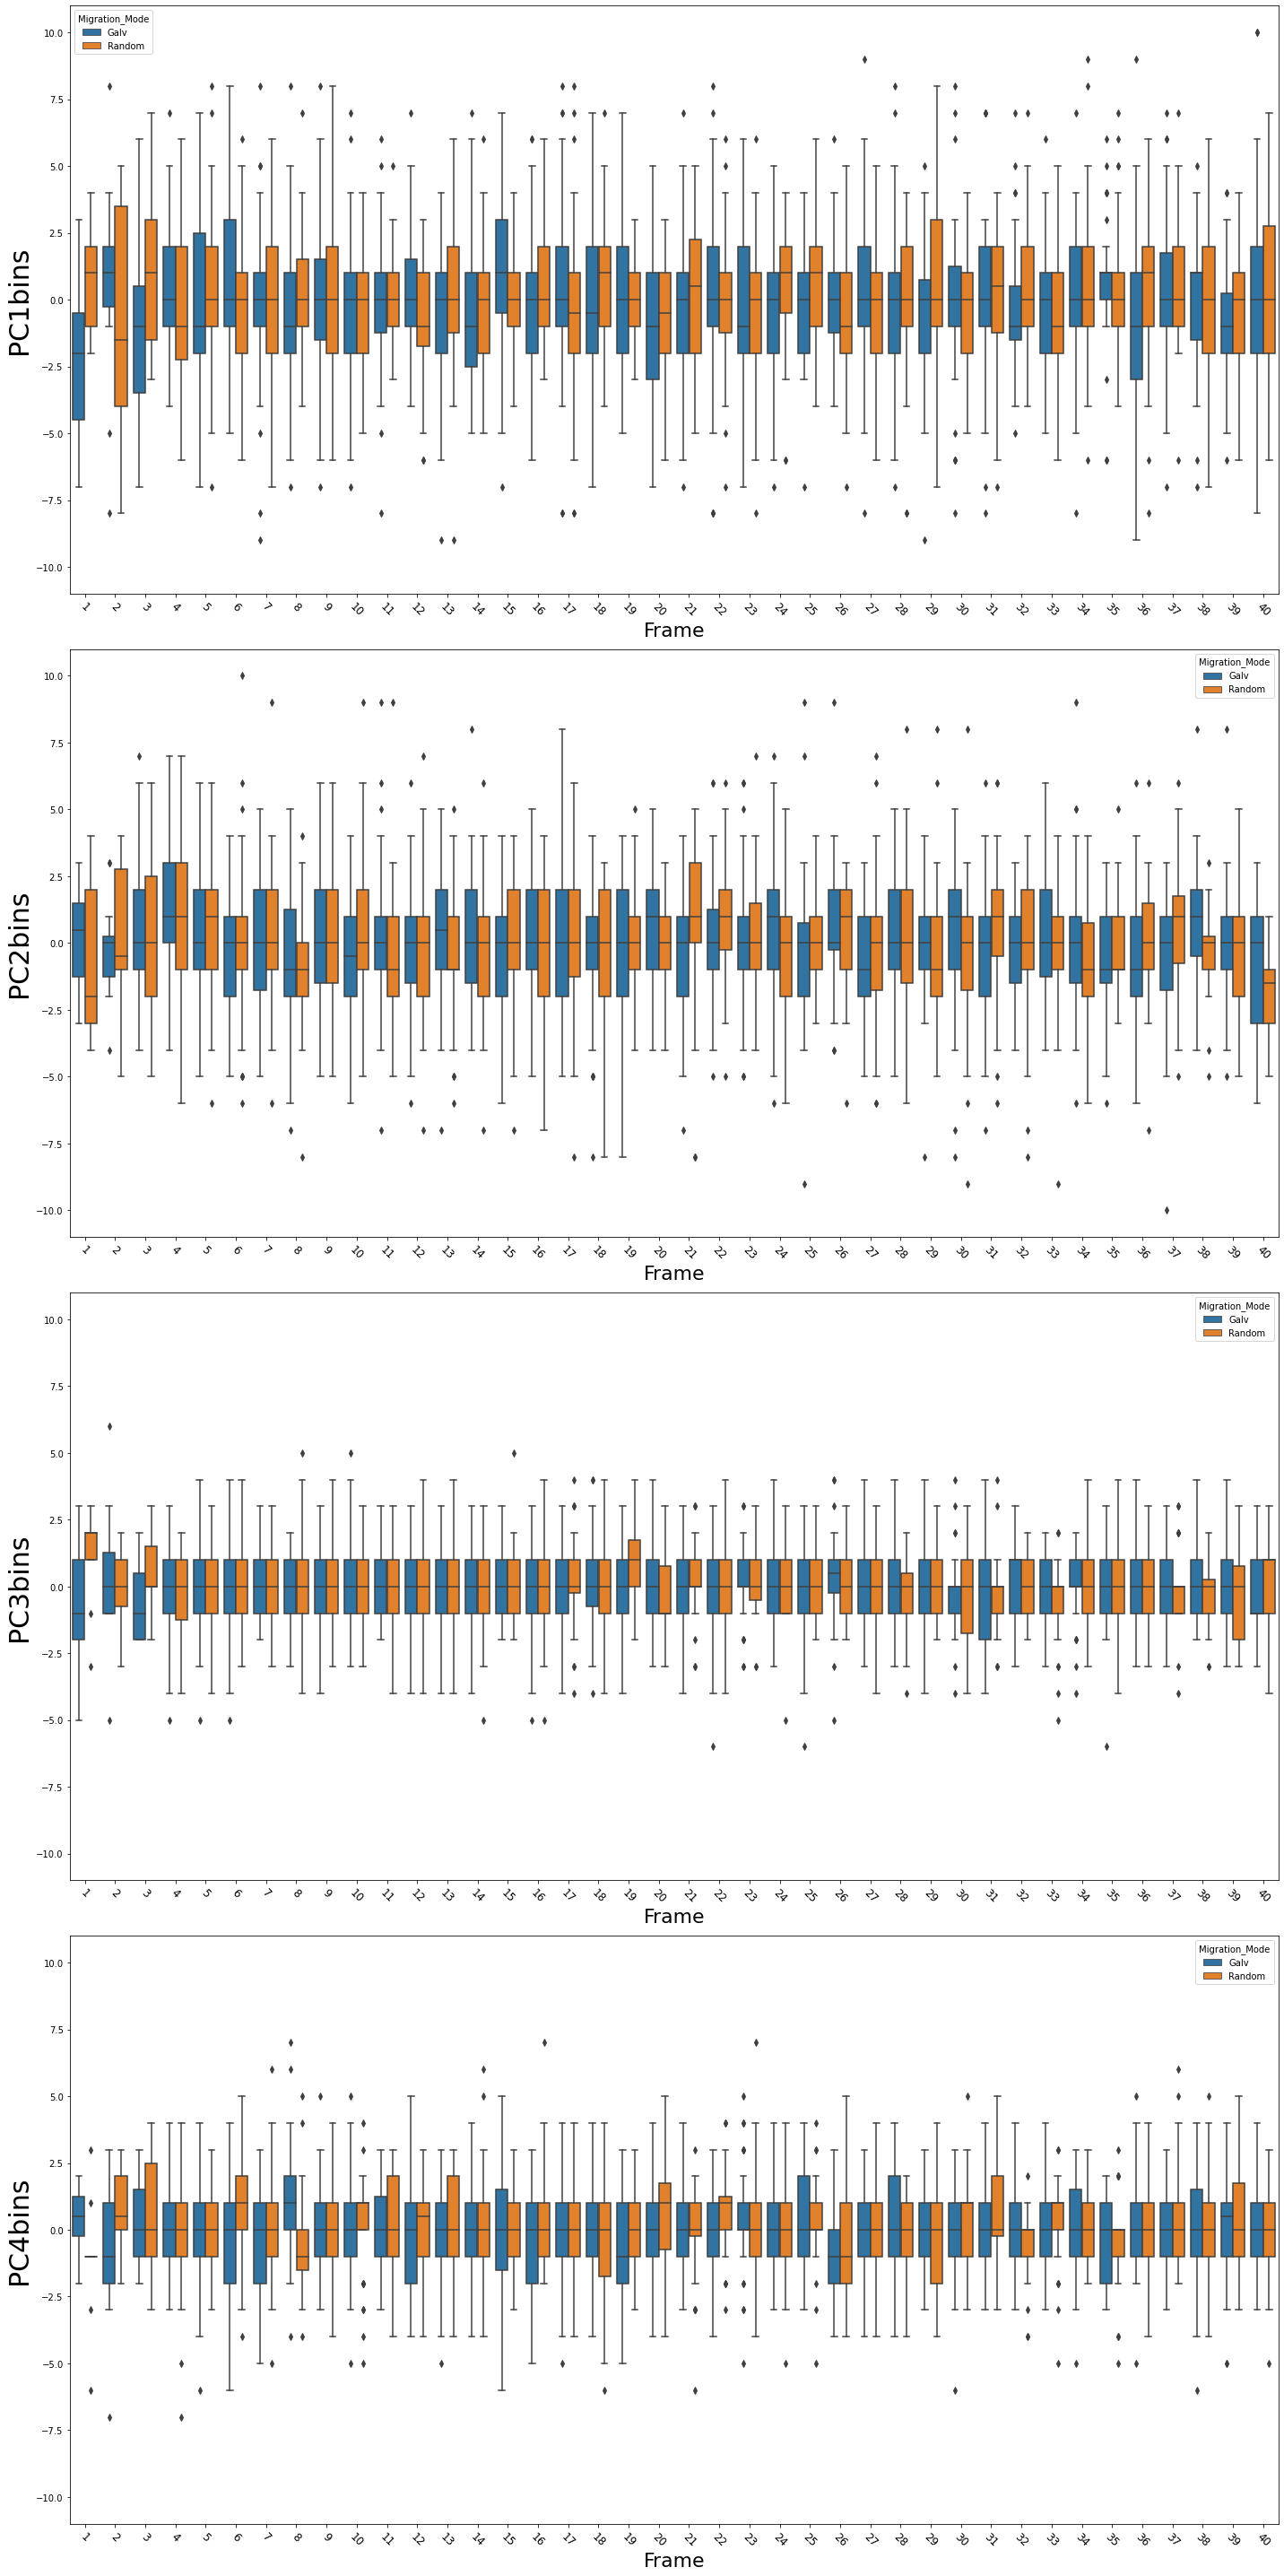

In [16]:
################## how are the PC bins changing over time #########################
difflist = []
for i, d in TotalFrame[['CellID','Migration_Mode','frame','PC1bins','PC2bins','PC3bins','PC4bins']].sort_values(by='frame').groupby('CellID'):
    dtemp = d[['frame','PC1bins','PC2bins','PC3bins','PC4bins']].diff()
    dtemp = dtemp[dtemp.frame==1]
    dtemp['frame'] = d.frame[dtemp.index]
    dtemp['CellID'] =  [i]*len(dtemp)
    dtemp['Migration_Mode'] = d.Migration_Mode[dtemp.index]
    difflist.append(dtemp)
diffdf = pd.concat(difflist)

fig, axes = plt.subplots(4, 1, figsize=(20,40), sharey=True)
for a, ax in enumerate(axes):
    cpc = [x for x in diffdf.columns.to_list() if 'PC' in x][a]
    sns.boxplot(data=diffdf, x='frame', hue='Migration_Mode',y=cpc, ax=ax)
    ax.set_xticklabels(
        np.sort(diffdf.frame.unique()).astype(int),
        rotation=-45,
        fontsize = 12
        )
    #set axis titles
    ax.set_ylabel(cpc, fontsize = 30)
    ax.set_xlabel('Frame', fontsize = 22)
plt.tight_layout()
fig.savefig(savedir+'PC bin differentials.png', facecolor='white')

In [6]:
########### interpolate all transitions so that only individual transitions are made ###########
from CustomFunctions.DetailedBalance import interpolate_2dtrajectory

time_interval = 15 #sec/frame

if (os.path.exists(savedir+'interpolated_PC1-PC2_transitions.csv')) & (os.path.exists(savedir+'interpolated_PC1-PC2_transition_pairs.csv')):
        
    transdf = pd.read_csv(savedir+'interpolated_PC1-PC2_transitions.csv')
    transpairsdf = pd.read_csv(savedir+'interpolated_PC1-PC2_transition_pairs.csv')
    print('Opened transition files')
    
else:

    if __name__ ==  '__main__':
        pool = multiprocessing.Pool(processes=60)
        results = []
        for i, cells in TotalFrame.groupby('CellID'):
            cells = cells.sort_values('frame').reset_index(drop = True)
            runs = list()
            #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
            for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                currentrun = list(map(itemgetter(1), g))
                list.append(runs, currentrun)

            for r in runs:
                r = np.array(r, dtype=int)
                #skip runs less than 3 frames long
                if len(r)<2:
                    pass
                else:
                    cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]

                    pool.apply_async(interpolate_2dtrajectory, args = (
                        time_interval,
                        cell.CellID.iloc[0],
                        cell.frame.to_list(),
                        cell[['PC1bins','PC2bins']].to_numpy(),
                        ),
                        callback = collect_results)
    pool.close()
    pool.join()


    transdf = pd.DataFrame(sum([r[0] for r in results],[]))
    transdf = transdf.sort_values(by = ['CellID','frame']).reset_index(drop=True)
    transpairsdf = pd.DataFrame(sum([r[1] for r in results],[]))
    transdf.to_csv(savedir+'interpolated_PC1-PC2_transitions.csv')
    transpairsdf.to_csv(savedir+'interpolated_PC1-PC2_transition_pairs.csv')

    print('Calculated transitions')
    
    


Calculated transitions


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


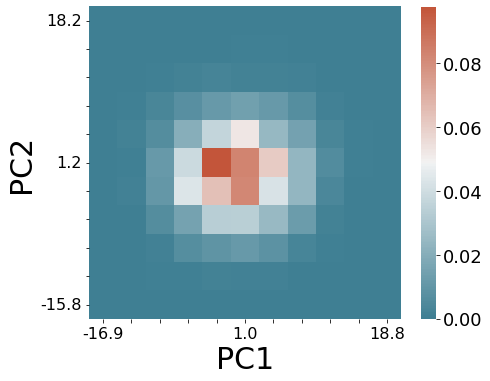

In [7]:
################ heatmap of probability density #############
#calculate the total time observed during the experiment
ttot = transdf.time_elapsed.sum()

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.sum()/ttot

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
    fontsize = 16
)
ax.set_yticklabels(
    [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC1_PC2 probability density heatmap.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


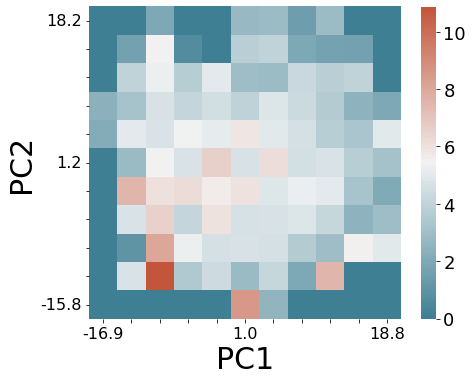

In [8]:
################ heatmap of AVERAGE DWELL TIME #############

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.mean()

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
    fontsize = 16
)
ax.set_yticklabels(
    [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC1_PC2 avg dwell time heatmap.png', bbox_inches='tight')

In [9]:
############## get the counts of cells leaving 

from CustomFunctions.DetailedBalance import get_transition_counts

if os.path.exists(savedir+'PC1-PC2_binned_transition_rates.csv'):
    trans_rate_df = pd.read_csv(savedir+'PC1-PC2_binned_transition_rates.csv')
    print('Opened transition rate files')
else:
    
    #calculate the total time observed during the experiment
    ttot = transdf.time_elapsed.sum()
    
    if __name__ ==  '__main__':
        pool = multiprocessing.Pool(processes=60)
        results = []
        for x in range(nbins):
            for y in range(nbins):
                fromm = transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)].reset_index(drop=True).to_dict()
                to = transdf[(transdf['to_x'] == x+1) & (transdf['to_y'] == y+1)].reset_index(drop=True).to_dict()
                pool.apply_async(get_transition_counts, args = (
                    x+1,
                    y+1,
                    fromm,
                    to,
                    ttot,
                    ),
                    callback = collect_results)
    pool.close()
    pool.join()

    trans_rate_df = pd.DataFrame(results)
    trans_rate_df = trans_rate_df.sort_values(by = ['x','y']).reset_index(drop=True)
    trans_rate_df.to_csv(savedir+'PC1-PC2_binned_transition_rates.csv')
    
    print('Calculated transition rates')

Calculated transition rates


In [13]:
from CustomFunctions.DetailedBalance import bootstrap_trajectories


#if a boostrapped data file already exists, load it, otherwise make one
if os.path.exists(savedir+'alldata_boostrapped_transitions.csv'):
    alldatabs = pd.read_csv(savedir+'alldata_boostrapped_transitions.csv', index_col=0)
    avg_cur = alldatabs.groupby(['x','y']).apply(np.mean)
    avg_cur = avg_cur.drop(columns = ['x','y']).reset_index()
    print('Opened bootstrap file')
else:
    #set the total boostrap time to the full time of a single video
    ttot = time_interval*TotalFrame.frame.max()
    
    #number of times to bootstrap
    bsiter = 5000

    start = 0
    stop = 300
    allresults = []
    while start<bsiter:
        if __name__ ==  '__main__':
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(start,stop):
                pool.apply_async(bootstrap_trajectories, args = (
                    transpairsdf,
                    ttot,
                    nbins,
                    ),
                    callback = collect_results)
            pool.close()
            pool.join()

            allresults.extend(results)

        start = stop + 1
        stop = stop + 300
        if stop>bsiter:
            stop = bsiter
        print(f'Finished {start} iterations, beginning the next {stop-start}')
    bslist = allresults.copy()
    # del results
    # del allresults
    avg_cur = pd.concat(bslist)
    avg_cur.to_csv(savedir+'alldata_boostrapped_transitions.csv')
    avg_cur = avg_cur.groupby(['x','y']).apply(np.mean)
    avg_cur = avg_cur.drop(columns = ['x','y']).reset_index()

    print('Finished boostrapping')

Finished 301 iterations, beginning the next 299
Finished 601 iterations, beginning the next 299
Finished 901 iterations, beginning the next 299
Finished 1201 iterations, beginning the next 299
Finished 1501 iterations, beginning the next 299
Finished 1801 iterations, beginning the next 299
Finished 2101 iterations, beginning the next 299
Finished 2401 iterations, beginning the next 299
Finished 2701 iterations, beginning the next 299
Finished 3001 iterations, beginning the next 299
Finished 3301 iterations, beginning the next 299
Finished 3601 iterations, beginning the next 299
Finished 3901 iterations, beginning the next 299
Finished 4201 iterations, beginning the next 299
Finished 4501 iterations, beginning the next 299
Finished 4801 iterations, beginning the next 199
Finished 5001 iterations, beginning the next -1
Finished boostrapping


In [11]:
#get current field for this bootstrap realization
bsfield = []
for x in range(nbins):
    for y in range(nbins):
        current = avg_cur[(avg_cur['x'] == x+1) & (avg_cur['y'] == y+1)]
        cov = np.cov(np.array([[-current.x_minus_rate.values[0]/2, current.x_plus_rate.values[0]/2,0,0],
                [0,0,-current.y_minus_rate.values[0]/2, current.y_plus_rate.values[0]/2]]))
        evals, evecs = np.linalg.eigh(cov)
        bsfield.append({'x':x+1,
                        'y':y+1,
                        'eval1':evals[1],
                        'eval2':evals[0],
                       'evec1x':evecs[0,1],
                       'evec1y':evecs[1,1],
                       'evec2x':evecs[0,0],
                       'evec2y':evecs[1,0]})
        
bsframe = pd.DataFrame(bsfield)

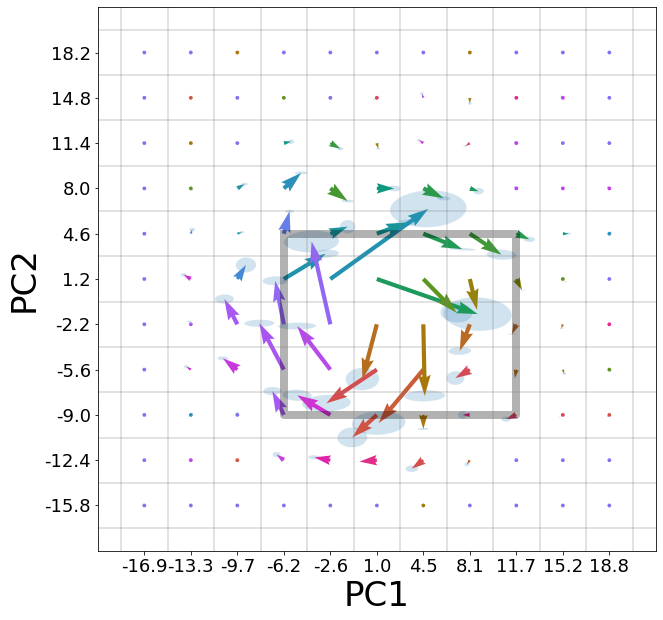

In [12]:
########## PC1/PC2 transition with error ellipses oriented to PCs ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0005

# combine fake error data with real transition data
elldf = bsframe.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})


fig, ax = plt.subplots(figsize=(10,10))

#add contou line if desired
uple = [4,7]
lori = [9,3]
contourcoords = contour_coords(uple,lori)

#actually plot the contour
ax.plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='black',alpha=0.3)



#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        
        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(current.eval1)*(1/scale)*2,
                  height=np.sqrt(current.eval2)*(1/scale)*2,
                angle=np.arctan2(current.evec1y,current.evec1x))
        ax.add_artist(ell)
        ell.set_alpha(0.2)
#         print(np.sqrt(current.eval1), np.sqrt(current.eval2))

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        ax.quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)))
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
ax.set_xlabel('PC1', fontsize = 34)
ax.set_ylabel('PC2', fontsize = 34)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 18)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 18)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)


# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)


plt.savefig(savedir + 'PC1_PC2 Vector map absolute angle colored contour.png', bbox_inches='tight')
#             print(x,y,current.deltaPC1.mean(), current.deltaPC2.mean(), x+current.deltaPC1.mean(), y+current.deltaPC2.mean())

In [40]:
from CustomFunctions.DetailedBalance import contour_integral

uple = [4,7]
lori = [9,3]
omegas = []
for b in bslist:
    omegas.append(contour_integral(b, uple, lori))
omegas = pd.DataFrame(list(zip(omegas/pd.Series(omegas).std(),['omega']*len(omegas))), columns=['value','sample'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


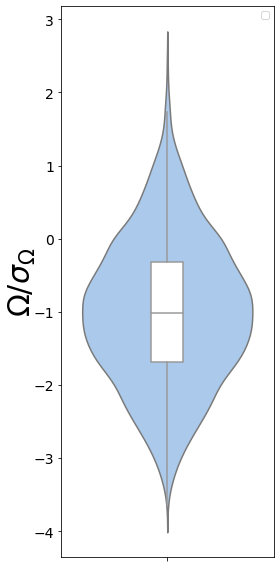

In [45]:
################ histograms of the contour integral distributions ###########

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=omegas, y = 'value',
               palette = colorlist, inner = None, ax=ax)
sns.boxplot(data=omegas,y='value', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=30, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels([''], fontsize = 14)



plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori}.png', bbox_inches='tight')


In [44]:
from statsmodels.stats.weightstats import ztest
ztest(omegas.value, value = 0)

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


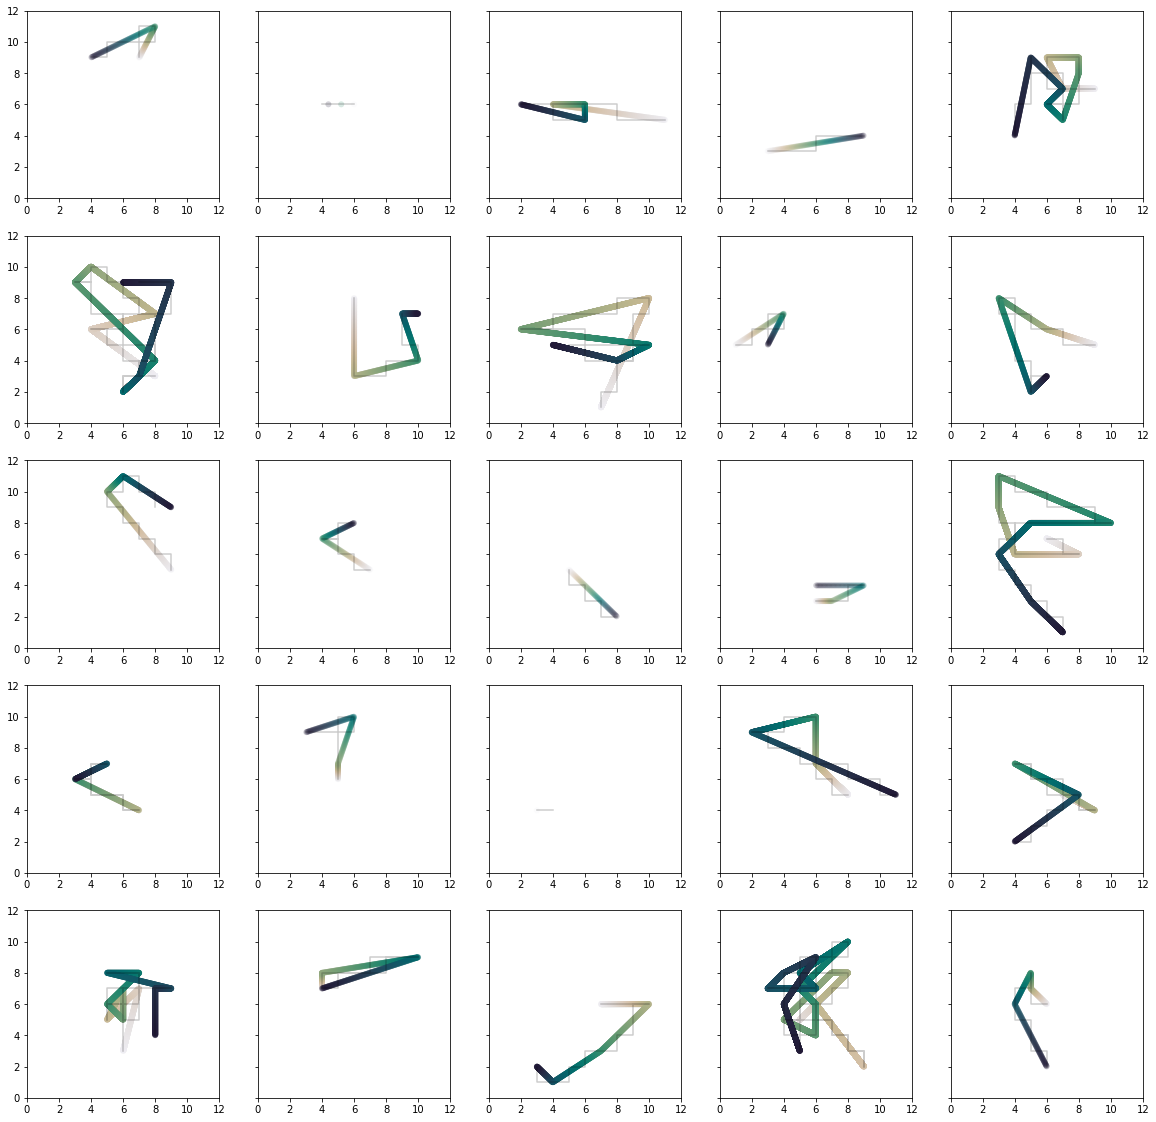

In [19]:
############# grid of plots of individual cells' INTERPOLATED transitions ###################

########### '20230509_488EGFP-CAAX_640SPY650-DNA2_cell_5' performs the exact loop #############

#the square root of plot number
pnum = 5
#randomly choose cells
sample = random.sample(list(transdf.CellID.unique()), pnum**2)

from cmocean import cm
norm = matplotlib.colors.Normalize()
cmm = cm.rain



fig, axes = plt.subplots(pnum,pnum,figsize=(20,20), sharey=True)
s = 0
#make numpy array with heatmap data
for x in range(pnum):
    for y in range(pnum):
        axes[x,y].set_xlim(0,nbins+1)
        axes[x,y].set_ylim(0,nbins+1)
        #get the next cell in the sample
        temp = transdf[transdf.CellID == sample[s]].reset_index(drop=True)
        #if temp is only 1 transition resample
        if len(temp)<2:
            temp = transdf[transdf.CellID == random.sample(list(transdf.CellID.unique()), 1)].reset_index(drop=True)
        #only get continuous frames 
        frames = temp[temp.frame.diff()>1].index.values
        if frames.size>0:
            if temp.index.values[0] != frames[0]:
                frames = np.append(temp.index.values[0], frames)
            if temp.index.values[-1] != frames[-1]:
                frames = np.append(frames, temp.index.values[-1])
            st = random.randrange(len(frames)-1)
            temp = temp.loc[frames[st]:frames[st+1]-1]
#             print(temp)
#         if s == len(sample)-1:
#             temp = alltrans.copy()
#             print(x,y)

        
        #get values of actual transitions based on the interpolated transitions
        fli = temp.frame.to_list()+[temp.frame.to_list()[-1]+1]
        acttemp = TotalFrame[(TotalFrame.CellID==temp.CellID.values[0])&(TotalFrame.frame.isin(fli))].sort_values(by='frame').reset_index(drop=True)
        #interpolate along the trajectory so I can plot dots which will represent the color gradient line
        px = acttemp.PC1bins.to_numpy()
        py = acttemp.PC2bins.to_numpy()
        pz = acttemp.frame.to_numpy()
        dist = np.nansum(scipy.spatial.distance.pdist(temp[['from_x','from_y']]))
        fx = scipy.interpolate.interp1d(np.arange(1,len(px)+1),px)
        newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
        fy = scipy.interpolate.interp1d(np.arange(1,len(py)+1),py)
        newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
        newz = np.arange(0,len(temp), len(temp)/len(newy))
        if len(newz)>len(newy):
            newz = newz[:-1]
        #normalize to the colors to the length of the trajectory
        norm.autoscale([0,newz.max()])
        #plot the actual transitions
        axes[x,y].scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.2, edgecolors='none')
        
        #plot the interpolated transitions
        ix = np.append(temp.from_x.to_numpy(), temp.to_x.to_numpy()[-1])
        iy = np.append(temp.from_y.to_numpy(), temp.to_y.to_numpy()[-1])
        axes[x,y].plot(ix, iy, color ='black', alpha=0.2)
        
        #add one to the sample count
        s = s+1

In [14]:
# for m, Mig in TotalFrame.groupby(['Migration_Mode','Experiment']):
#     print('_'.join(m))
TotalFrame.Migration_Mode.unique()

array(['Random', 'Chem_Directed', 'Galv'], dtype=object)

In [11]:
########### interpolate all transitions so that only individual transitions are made ###########
from CustomFunctions.DetailedBalance import interpolate_2dtrajectory

time_interval = 15 #sec/frame


if (os.path.exists(savedir+'interpolated_PC1-PC2_transitions_separated.csv')) & (os.path.exists(savedir+'interpolated_PC1-PC2_transition_pairs_separated.csv')):
        
    transdf_sep = pd.read_csv(savedir+'interpolated_PC1-PC2_transitions_separated.csv', index_col=0)
    transpairsdf_sep = pd.read_csv(savedir+'interpolated_PC1-PC2_transition_pairs_separated.csv', index_col=0)
    print('Opened transition files')
    
else:
    if __name__ ==  '__main__':
        migresults = []
        for m, Mig in TotalFrame.groupby('Migration_Mode'):
            results = []
            pool = multiprocessing.Pool(processes=60)
            for i, cells in Mig.groupby('CellID'):
                cells = cells.sort_values('frame').reset_index(drop = True)
                runs = list()
                #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
                for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                    currentrun = list(map(itemgetter(1), g))
                    list.append(runs, currentrun)

                for r in runs:
                    r = np.array(r, dtype=int)
                    #skip runs less than 3 frames long
                    if len(r)<2:
                        pass
                    else:
                        cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]

                        pool.apply_async(interpolate_2dtrajectory, args = (
                            time_interval,
                            cell.CellID.iloc[0],
                            cell.frame.to_list(),
                            cell[['PC1bins','PC2bins']].to_numpy(),
                            ),
                            callback = collect_results)
            pool.close()
            pool.join()


            transdf_sep = pd.DataFrame(sum([r[0] for r in results],[]))
            transdf_sep = transdf_sep.sort_values(by = ['CellID','frame']).reset_index(drop=True)
            transpairsdf_sep = pd.DataFrame(sum([r[1] for r in results],[]))
            transdf_sep['Migration_Mode'] = [m]*len(transdf_sep)
            transpairsdf_sep['Migration_Mode'] = [m]*len(transpairsdf_sep)
            migresults.append([transdf_sep,transpairsdf_sep])

    transdf_sep = pd.concat([mi[0] for mi in migresults])
    transpairsdf_sep = pd.concat([mi[1] for mi in migresults])
    transdf_sep.to_csv(savedir+'interpolated_PC1-PC2_transitions_separated.csv')
    transpairsdf_sep.to_csv(savedir+'interpolated_PC1-PC2_transition_pairs_separated.csv')
    del migresults
    print('Finished interpolating trajectories')
############## get the counts of cells leaving 

from CustomFunctions.DetailedBalance import get_transition_counts
if os.path.exists(savedir+'PC1-PC2_binned_transition_rates_separated.csv'):
    trans_rate_df_sep = pd.read_csv(savedir+'PC1-PC2_binned_transition_rates_separated.csv', index_col=0)
    print('Opened transition rate files')
else:
    trresults = []
    if __name__ ==  '__main__':
        for m, mig in transdf_sep.groupby('Migration_Mode'):
            ttot = mig.time_elapsed.sum()
            print(ttot)
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(nbins):
                for y in range(nbins):
                    fromm = mig[(mig['from_x'] == x+1) & (mig['from_y'] == y+1)].reset_index(drop=True).to_dict()
                    to = mig[(mig['to_x'] == x+1) & (mig['to_y'] == y+1)].reset_index(drop=True).to_dict()
                    pool.apply_async(get_transition_counts, args = (
                        x+1,
                        y+1,
                        fromm,
                        to,
                        ttot,
                        ),
                        callback = collect_results)
            pool.close()
            pool.join()

            trans_rate_df_sep = pd.DataFrame(results)
            trans_rate_df_sep['Migration_Mode'] = [m]*len(trans_rate_df_sep)
            trans_rate_df_sep = trans_rate_df_sep.sort_values(by = ['x','y']).reset_index(drop=True)
            trresults.append(trans_rate_df_sep)

    trans_rate_df_sep = pd.concat(trresults)
    trans_rate_df_sep.to_csv(savedir+'PC1-PC2_binned_transition_rates_separated.csv')
    del trresults

    print('Finished finding transition rates')


############## BOOTSTRAP MANY TRAJECTORIES ##########
from CustomFunctions.DetailedBalance import bootstrap_trajectories

modes = transpairsdf_sep.Migration_Mode.unique()
#if a boostrapped data file already exists, load it, otherwise make one
if (os.path.exists(savedir+f'{modes[0]}_boostrapped_transitions.csv')) & (os.path.exists(savedir+f'{modes[1]}_boostrapped_transitions.csv')):
    avg_cur_mode1 = pd.read_csv(savedir+f'{modes[0]}_boostrapped_transitions.csv', index_col=0)
    avgavg_cur_mode1 = avg_cur_mode1.groupby(['x','y','Migration_Mode']).apply(np.mean)
    avgavg_cur_mode1 = avgavg_cur_mode1.drop(columns = ['x','y']).reset_index()
    avg_cur_mode2 = pd.read_csv(savedir+f'{modes[1]}_boostrapped_transitions.csv', index_col=0)
    avgavg_cur_mode2 = avg_cur_mode2.groupby(['x','y','Migration_Mode']).apply(np.mean)
    avgavg_cur_mode2 = avgavg_cur_mode2.drop(columns = ['x','y']).reset_index()
    avg_cur_mode3 = pd.read_csv(savedir+f'{modes[2]}_boostrapped_transitions.csv', index_col=0)
    avgavg_cur_mode3 = avg_cur_mode3.groupby(['x','y','Migration_Mode']).apply(np.mean)
    avgavg_cur_mode3 = avgavg_cur_mode3.drop(columns = ['x','y']).reset_index()
    bsframe_sep = pd.concat([avgavg_cur_mode1,avgavg_cur_mode2,avgavg_cur_mode3])
    bsframe_sep_full = pd.concat([avg_cur_mode1,avg_cur_mode2,avg_cur_mode3])
    del avg_cur_mode1
    del avg_cur_mode2
    del avg_cur_mode3
    del avgavg_cur_mode1
    del avgavg_cur_mode2
    del avgavg_cur_mode3
    
    print('Opened bootstrap file')
else:
    
    #set the total boostrap time to the full time of a single video
    ttot = time_interval*TotalFrame.frame.max()
    
    bsresults = []
    #number of times to bootstrap
    bsiter = 5000

    for m, mig in transpairsdf_sep.groupby('Migration_Mode'):
        start = 0
        stop = 300
        allresults = []
        while stop<bsiter:
            if __name__ ==  '__main__':
                pool = multiprocessing.Pool(processes=60)
                results = []
                for x in range(start,stop):
                    pool.apply_async(bootstrap_trajectories, args = (
                        mig,
                        ttot,
                        nbins,
                        ),
                        callback = collect_results)
                pool.close()
                pool.join()

                allresults.extend(results)

            start = stop + 1
            stop = stop + 300
            if stop>bsiter:
                stop = bsiter
            print(f'Finished {start} iterations, beginning the next {stop-start}')
        migboot = pd.concat(allresults)
        migboot['Migration_Mode'] = [m]*len(migboot)
        migboot.to_csv(savedir+f'{m}_boostrapped_transitions.csv')
        bsresults.append(migboot)
        

    bsframe_sep = pd.concat(bsresults)
    del results
    del allresults
    print('Finished boostrapping')


Opened transition files
Opened transition rate files


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Opened bootstrap file


In [14]:
len(transdf_sep[transdf_sep.Migration_Mode=='Chem_Directed']), len(transdf_sep[transdf_sep.Migration_Mode=='Random'])

(7325, 17272)

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator


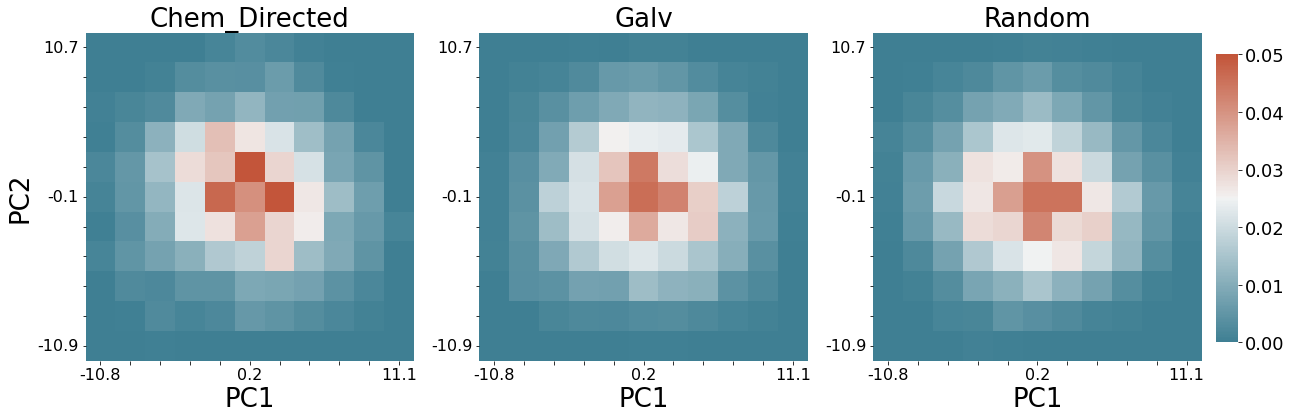

In [12]:
########### PLOT THE DISTRIBUTIONS OF THE SEPARATED MIGRATION MODES #############



fig, axes = plt.subplots(1,len(transdf_sep.Migration_Mode.unique()),figsize=(20,10))
#single colorbar axis
cbar_ax = fig.add_axes([.91, .3, .015, .4])

for i, ax in enumerate(axes):
    mm = transdf_sep.Migration_Mode.unique()[i]
    mdf = transdf_sep[transdf_sep.Migration_Mode==mm]
    ttot = mdf.time_elapsed.sum()
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.time_elapsed.sum()/ttot

        
    #plot heatmap with seaborn
    sns.heatmap(
        bighm,
        vmin=0, vmax=0.05, #center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
        fontsize = 16
    )
    ax.set_yticklabels(
        [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
        rotation=0,
        fontsize = 16
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 26)
    
plt.savefig(savedir + 'PC1_PC2 probability density heatmap separated.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator


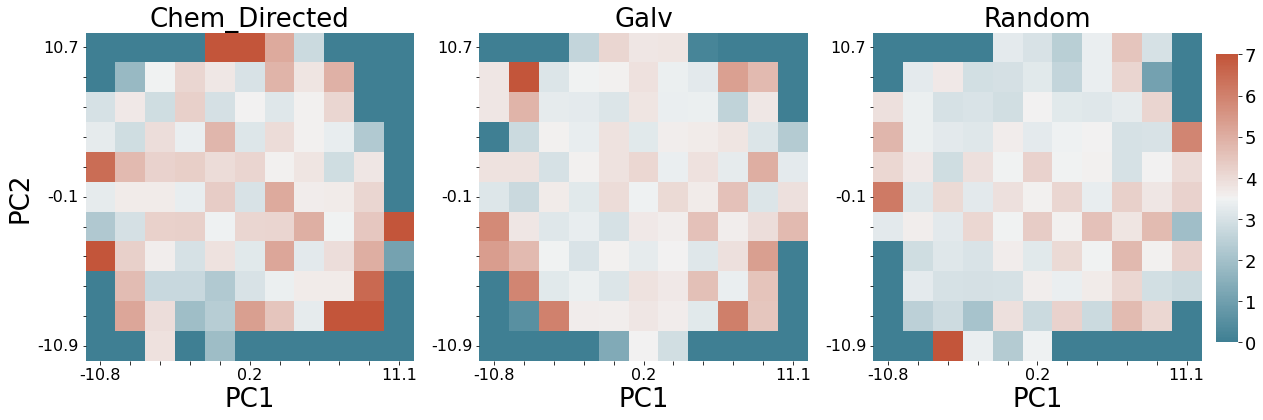

In [23]:
########### PLOT THE DWELL TIME OF THE MIGRATION MODES IN THE CGPS #############

fig, axes = plt.subplots(1,len(transdf_sep.Migration_Mode.unique()),figsize=(20,10))
#single colorbar axis
cbar_ax = fig.add_axes([.91, .3, .015, .4])

for i, ax in enumerate(axes):
    mm = transdf_sep.Migration_Mode.unique()[i]
    mdf = transdf_sep[transdf_sep.Migration_Mode==mm]
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.time_elapsed.mean()

        
    #plot heatmap with seaborn
    sns.heatmap(
        bighm,
        vmin=0, vmax=7, #center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
        fontsize = 16
    )
    ax.set_yticklabels(
        [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
        rotation=0,
        fontsize = 16
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 26)
    
plt.savefig(savedir + 'PC1_PC2 probability dwell time heatmap separated.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(127.625, 0.5, 'PC2')

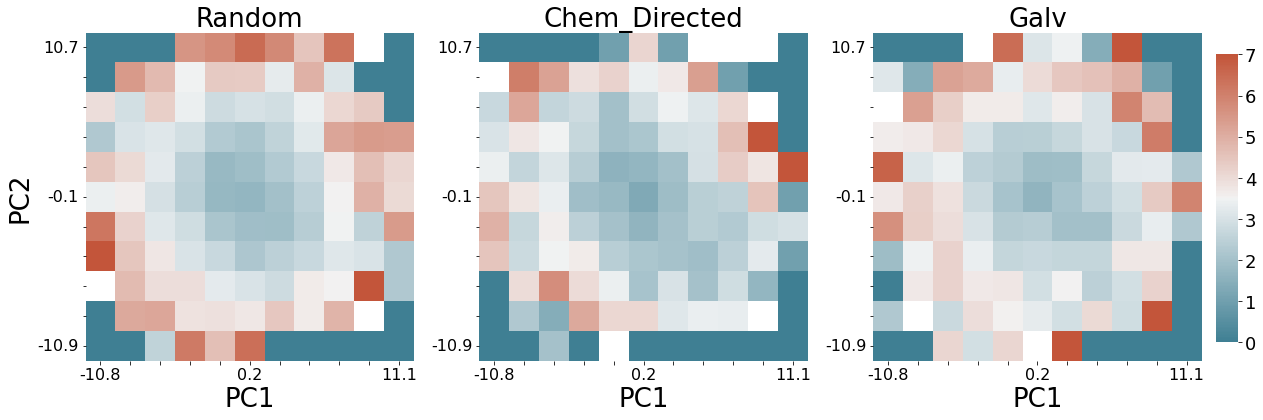

In [96]:
############ calculate the distance travelled between time points in the PC1-PC2 CGPS ##########
to = []
fromm = []
idd = []
for i, cells in TotalFrame.sort_values('frame').groupby('CellID'):
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)

    for r in runs:
        r = np.array(r, dtype=int)
        cell = cells[cells.frame.isin(r)]
        tdiffs = cell[['PC1bins','PC2bins']].diff()
        fdiffs = cell[['PC1bins','PC2bins']].diff(-1)
        PC1_PC2_distance_to = []
        PC1_PC2_distance_from = []
        for d in range(len(cell)):
            #calculate the change distance the cell HAS travelled
            PC1_PC2_distance_to.append(np.sqrt(tdiffs.iloc[d].PC1bins**2 + tdiffs.iloc[d].PC2bins**2))
            #calculate the change distance the cell WILL travel
            PC1_PC2_distance_from.append(np.sqrt(fdiffs.iloc[d].PC1bins**2 + fdiffs.iloc[d].PC2bins**2))
        to.extend(PC1_PC2_distance_to)
        fromm.extend(PC1_PC2_distance_from)
        idd.extend(cell.cell.to_list())
#add them to the the total dataframe
TotalFrame = TotalFrame.merge(pd.DataFrame({'cell':idd,
              'PC1_PC2_distance_to':to,
              'PC1_PC2_distance_from':fromm}),
              left_on = ['cell'],
            right_on = ['cell'])




########### PLOT THE DWELL TIME OF THE MIGRATION MODES IN THE CGPS #############

fig, axes = plt.subplots(1,len(transdf_sep.Migration_Mode.unique()),figsize=(20,10))
#single colorbar axis
cbar_ax = fig.add_axes([.91, .3, .015, .4])

for i, ax in enumerate(axes):
    mm = TotalFrame.Migration_Mode.unique()[i]
    mdf = TotalFrame[TotalFrame.Migration_Mode==mm]
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC2bins'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.PC1_PC2_distance_to.mean()

        
    #plot heatmap with seaborn
    sns.heatmap(
        bighm,
        vmin=0, vmax=7, #center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
        fontsize = 16
    )
    ax.set_yticklabels(
        [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
        rotation=0,
        fontsize = 16
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 26)
    
# plt.savefig(savedir + 'PC1_PC2 probability dwell time heatmap separated.png', bbox_inches='tight')

In [ ]:
########### PLOT THE AVERAGE SHAPE CHANGE (DISTANCE) OF THE MIGRATION MODES IN THE CGPS #############

fig, axes = plt.subplots(1,len(transdf_sep.Migration_Mode.unique()),figsize=(20,10))
#single colorbar axis
cbar_ax = fig.add_axes([.91, .3, .015, .4])

for i, ax in enumerate(axes):
    mm = transdf_sep.Migration_Mode.unique()[i]
    mdf = transdf_sep[transdf_sep.Migration_Mode==mm]
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.time_elapsed.mean()

        
    #plot heatmap with seaborn
    sns.heatmap(
        bighm,
        vmin=0, vmax=7, #center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
        fontsize = 16
    )
    ax.set_yticklabels(
        [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
        rotation=0,
        fontsize = 16
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 26)
    
plt.savefig(savedir + 'PC1_PC2 probability dwell time heatmap separated.png', bbox_inches='tight')

In [7]:
#### get current field for this bootstrap realization ######
####### this is for looking at data spread for the current field ############
bsfield = []
for m, mig in bsframe_sep.groupby('Migration_Mode'):
    for x in range(nbins):
        for y in range(nbins):
            current = mig[(mig['x'] == x+1) & (mig['y'] == y+1)]
            cov = np.cov(np.array([[-current.x_minus_rate.values[0]/2, current.x_plus_rate.values[0]/2,0,0],
                    [0,0,-current.y_minus_rate.values[0]/2, current.y_plus_rate.values[0]/2]]))
            evals, evecs = np.linalg.eigh(cov)
            bsfield.append({'x':x+1,
                            'y':y+1,
                            'eval1':evals[1],
                            'eval2':evals[0],
                           'evec1x':evecs[0,1],
                           'evec1y':evecs[1,1],
                           'evec2x':evecs[0,0],
                           'evec2y':evecs[1,0],
                          'Migration_Mode':m})
        
bsfield_sep = pd.DataFrame(bsfield)

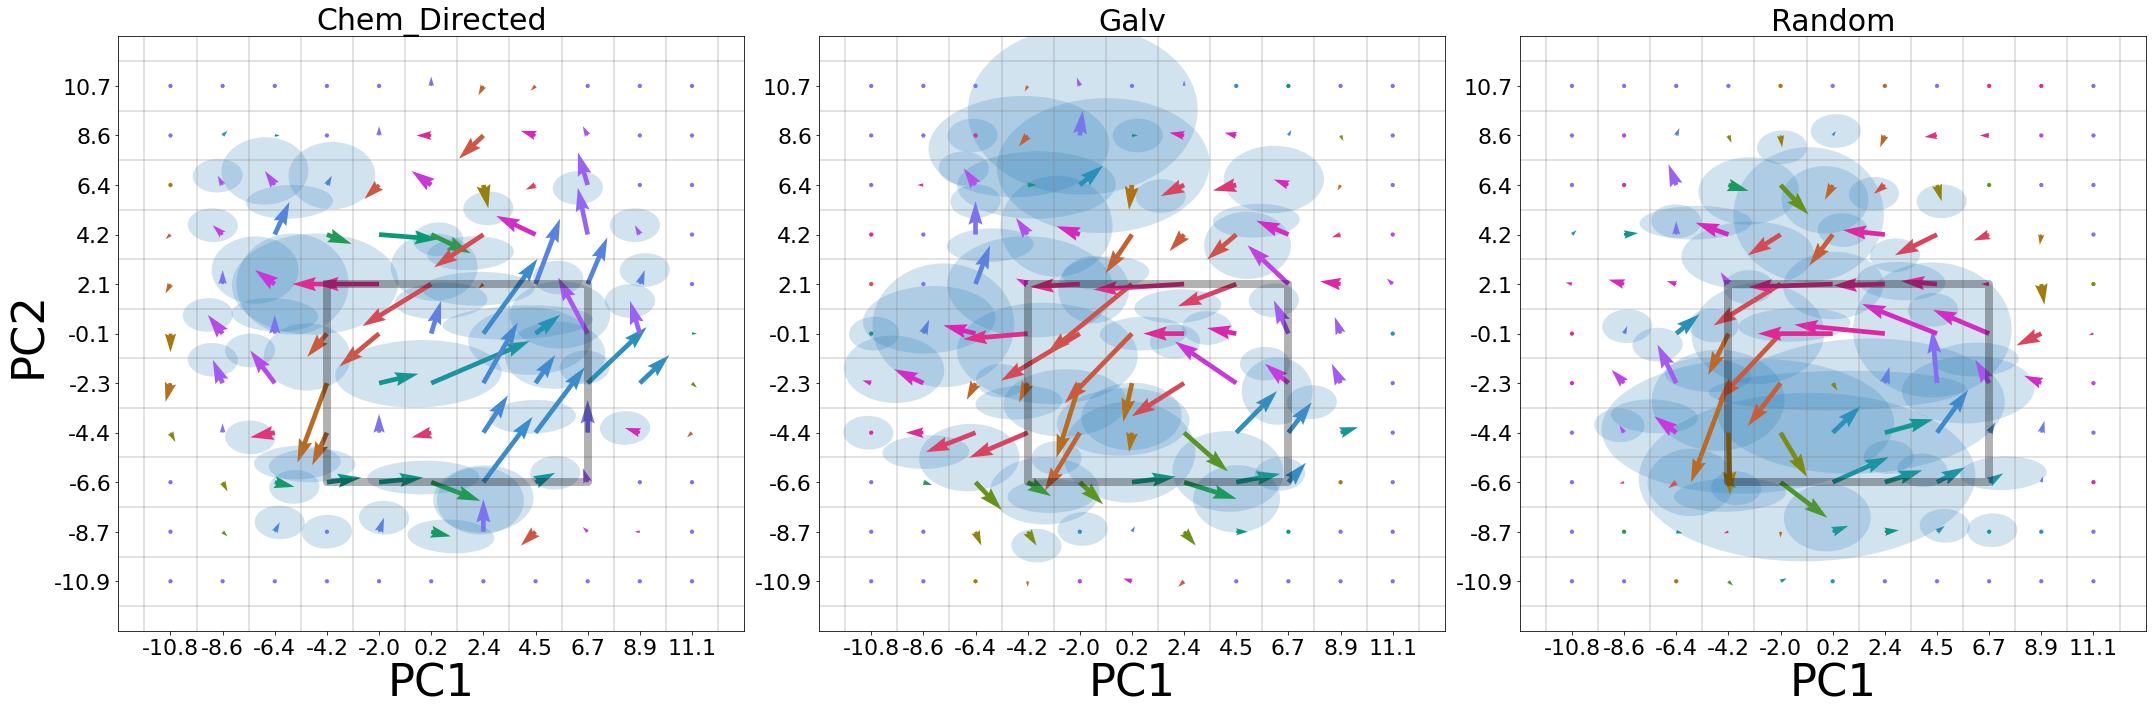

In [15]:
############## plot vectors of PC1/2 transitions from different migration modes #################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from CustomFunctions.DetailedBalance import contour_coords

# inverse scale for arrows
scale = 0.0005


# combine error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df_sep,left_on = ['x','y','Migration_Mode'], right_on = ['x','y','Migration_Mode'])


#do color scales stuff
norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})

#subplots
fig, axes = plt.subplots(1,len(elldf.Migration_Mode.unique()),figsize=(30,10))
for i, ax in enumerate(axes):
    mm = elldf.Migration_Mode.unique()[i]
    mdf = elldf[elldf.Migration_Mode==mm]
    #add "grid lines" first 
    for h in np.linspace(0.5, nbins+0.5, nbins+1):
        ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
        ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

    #add contou line if desired
    uple = [4,7]
    lori = [9,3]
    contourcoords = contour_coords(uple,lori)
    #actually plot the contour
    ax.plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='black',alpha=0.3)

        
    for x in range(1,nbins+1):
        for y in range(1,nbins+1):
            current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
            xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
            ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

            ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                    width=np.sqrt(abs(current.eval1))*(1/scale)*2,
                      height=np.sqrt(abs(current.eval2))*(1/scale)*2,
                    angle=np.arctan2(current.evec1y,current.evec1x))
            ax.add_artist(ell)
            ell.set_alpha(0.2)

    for x in range(1,nbins+1):
        for y in range(1,nbins+1):
            current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
            xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
            ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
            anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
            ax.quiver(x,
                       y, 
                       xcurrent,
                       ycurrent,
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = scale,
#                       width = 0.012,
#                       minlength = 0.8,
                      color = cmm(norm(anglecolor)))


    #         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
    ax.set_xlabel('PC1', fontsize = 45)

    ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 22)
    ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 22)
    ax.set_xlim(0,nbins+1)
    ax.set_ylim(0,nbins+1)
    ax.set_title(mm, fontsize = 30)
    
    
axes[0].set_ylabel('PC2', fontsize = 45)
plt.tight_layout()

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)


plt.savefig(savedir + 'PC1_PC2 Vector map absolute angle colored separated.png', bbox_inches='tight')


In [13]:
######### do contour integrals for all migration modes ################
import itertools
from CustomFunctions.DetailedBalance import contour_integral
#upper left position of contour box
uple = [4,7]
#lower right position of contour box
lori = [9,3]

if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated.csv'):
    omegaframesep = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated.csv', index_col=0)
else:
    omega_results = []
    for i, m in bsframe_sep_full.groupby('Migration_Mode'):
        omegas = []
        iters = [[x]*(nbins**2) for x in range(int(len(m)/(nbins**2)))]#, len(migboot)
        m['bs_iteration'] = list(itertools.chain.from_iterable(iters))
        for l, b in m.groupby('bs_iteration'):
            omegas.append(contour_integral(b, uple, lori, False))
        omega_results.append([i,omegas])
    omegaframesep = pd.DataFrame([o[1] for o in omega_results], index = [o[0] for o in omega_results])
    dlist = []
    for m in omegaframesep.T.columns.to_list():
        dlist.append(pd.DataFrame(list(zip(omegaframesep.T[m].to_list(), [m]*len(omegaframesep.T))), columns=['boostrap_omega','Migration_Mode']))
    omegaframesep = pd.concat(dlist)
    omegaframesep.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated.csv')

In [14]:
omegaframesep

,boostrap_omega,Migration_Mode
0,-0.012946,Chem_Directed
1,-0.017155,Chem_Directed
2,0.012429,Chem_Directed
3,0.002673,Chem_Directed
4,-0.011839,Chem_Directed
...,...,...
4780,-0.006940,Random
4781,-0.002184,Random
4782,-0.001738,Random
4783,-0.000955,Random


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


F value: 14.176266738901665, p value: 7.069665618385963e-07
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
    group1    group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
Chem_Directed   Galv  -0.0003 0.0822 -0.0006     0.0  False
Chem_Directed Random  -0.0007    0.0  -0.001 -0.0004   True
         Galv Random  -0.0004 0.0046 -0.0007 -0.0001   True
-----------------------------------------------------------


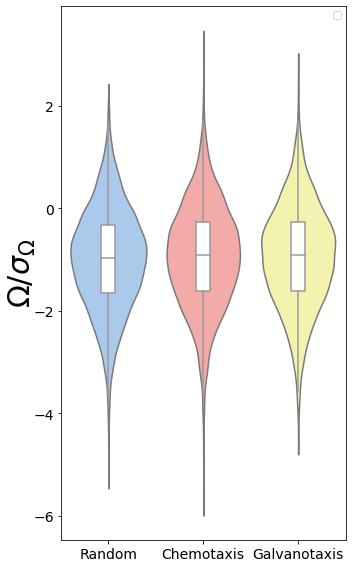

In [15]:
################ histograms of the contour integral distributions ###########

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

#calculate the normalized omegas
stds = []
for i,m in omegaframesep.groupby('Migration_Mode'):
    stds.extend(m.boostrap_omega/m.boostrap_omega.std())
omegaframesep['Norm_Omegas'] = stds

fig, ax = plt.subplots(figsize=(5,8))#, sharex=True)
#plots
sns.violinplot(data=omegaframesep, x='Migration_Mode', y='Norm_Omegas', 
               palette = colorlist, inner = None, ax=ax, order=['Random', 'Chem_Directed', 'Galv'])
sns.boxplot(data=omegaframesep, x='Migration_Mode', y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax, order=['Random', 'Chem_Directed', 'Galv'])

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=30, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels(['Random','Chemotaxis','Galvanotaxis'], fontsize = 14)



plt.legend()
plt.tight_layout()

# plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori} separated.png', bbox_inches='tight')


import scipy.stats as ss


f_val, p_val = ss.f_oneway(*[m.boostrap_omega.to_list() for i,m in omegaframesep.groupby('Migration_Mode')])
print(f'F value: {f_val}, p value: {p_val}')
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(omegaframesep.boostrap_omega, omegaframesep.Migration_Mode))



In [22]:
######## breakdown transition analysis by experiment AND migration mode #############

########### interpolate all transitions so that only individual transitions are made ###########
from CustomFunctions.DetailedBalance import interpolate_2dtrajectory

time_interval = 15 #sec/frame


if (os.path.exists(savedir+'interpolated_PC1-PC2_transitions_expseparated.csv')) & (os.path.exists(savedir+'interpolated_PC1-PC2_transition_pairs_expseparated.csv')):
        
    transdf_expsep = pd.read_csv(savedir+'interpolated_PC1-PC2_transitions_expseparated.csv', index_col=0)
    transpairsdf_expsep = pd.read_csv(savedir+'interpolated_PC1-PC2_transition_pairs_expseparated.csv', index_col=0)
    print('Opened transition files')
    
else:
    if __name__ ==  '__main__':
        migresults = []
        for m, Mig in TotalFrame.groupby(['Migration_Mode','Experiment']):
            results = []
            pool = multiprocessing.Pool(processes=60)
            for i, cells in Mig.groupby('CellID'):
                cells = cells.sort_values('frame').reset_index(drop = True)
                runs = list()
                #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
                for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                    currentrun = list(map(itemgetter(1), g))
                    list.append(runs, currentrun)

                for r in runs:
                    r = np.array(r, dtype=int)
                    #skip runs less than 3 frames long
                    if len(r)<2:
                        pass
                    else:
                        cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]

                        pool.apply_async(interpolate_2dtrajectory, args = (
                            time_interval,
                            cell.CellID.iloc[0],
                            cell.frame.to_list(),
                            cell[['PC1bins','PC2bins']].to_numpy(),
                            ),
                            callback = collect_results)
            pool.close()
            pool.join()


            transdf_expsep = pd.DataFrame(sum([r[0] for r in results],[]))
            transdf_expsep = transdf_expsep.sort_values(by = ['CellID','frame']).reset_index(drop=True)
            transpairsdf_expsep = pd.DataFrame(sum([r[1] for r in results],[]))
            transdf_expsep['Migration_Mode'] = ['_'.join(m)]*len(transdf_expsep)
            transpairsdf_expsep['Migration_Mode'] = ['_'.join(m)]*len(transpairsdf_expsep)
            migresults.append([transdf_expsep,transpairsdf_expsep])

    transdf_expsep = pd.concat([mi[0] for mi in migresults])
    transpairsdf_expsep = pd.concat([mi[1] for mi in migresults])
    transdf_expsep.to_csv(savedir+'interpolated_PC1-PC2_transitions_expseparated.csv')
    transpairsdf_expsep.to_csv(savedir+'interpolated_PC1-PC2_transition_pairs_expseparated.csv')
    del migresults
    print('Finished interpolating trajectories')
############## get the counts of cells leaving 

from CustomFunctions.DetailedBalance import get_transition_counts
if os.path.exists(savedir+'PC1-PC2_binned_transition_rates_expseparated.csv'):
    trans_rate_df_expsep = pd.read_csv(savedir+'PC1-PC2_binned_transition_rates_expseparated.csv', index_col=0)
    print('Opened transition rate files')
else:
    trresults = []
    if __name__ ==  '__main__':
        for m, mig in transdf_expsep.groupby('Migration_Mode'):
            ttot = mig.time_elapsed.sum()
            print(ttot)
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(nbins):
                for y in range(nbins):
                    fromm = mig[(mig['from_x'] == x+1) & (mig['from_y'] == y+1)].reset_index(drop=True).to_dict()
                    to = mig[(mig['to_x'] == x+1) & (mig['to_y'] == y+1)].reset_index(drop=True).to_dict()
                    pool.apply_async(get_transition_counts, args = (
                        x+1,
                        y+1,
                        fromm,
                        to,
                        ttot,
                        ),
                        callback = collect_results)
            pool.close()
            pool.join()

            trans_rate_df_expsep = pd.DataFrame(results)
            trans_rate_df_expsep['Migration_Mode'] = [m]*len(trans_rate_df_expsep)
            trans_rate_df_expsep = trans_rate_df_expsep.sort_values(by = ['x','y']).reset_index(drop=True)
            trresults.append(trans_rate_df_expsep)

    trans_rate_df_expsep = pd.concat(trresults)
    trans_rate_df_expsep.to_csv(savedir+'PC1-PC2_binned_transition_rates_expseparated.csv')
    del trresults

    print('Finished finding transition rates')


############## BOOTSTRAP MANY TRAJECTORIES ##########
from CustomFunctions.DetailedBalance import bootstrap_trajectories

modes = transpairsdf_expsep.Migration_Mode.unique()
#if a boostrapped data file already exists, load it, otherwise make one
if (os.path.exists(savedir+f'{modes[0]}_boostrapped_transitions.csv')) & (
    os.path.exists(savedir+f'{modes[1]}_boostrapped_transitions.csv')) & (
    os.path.exists(savedir+f'{modes[2]}_boostrapped_transitions.csv')) & (
    os.path.exists(savedir+f'{modes[3]}_boostrapped_transitions.csv')):
    #open and group the full number of bootstraps
    avg_cur_mode1 = pd.read_csv(savedir+f'{modes[0]}_boostrapped_transitions.csv', index_col=0)
    avg_cur_mode2 = pd.read_csv(savedir+f'{modes[1]}_boostrapped_transitions.csv', index_col=0)
    avg_cur_mode3 = pd.read_csv(savedir+f'{modes[2]}_boostrapped_transitions.csv', index_col=0)
    avg_cur_mode4 = pd.read_csv(savedir+f'{modes[3]}_boostrapped_transitions.csv', index_col=0)
    bsframe_expsep_full = pd.concat([avg_cur_mode1,avg_cur_mode2,avg_cur_mode3,avg_cur_mode4])
    
    #get bootstrap averages
    avg_cur_mode1 = avg_cur_mode1.groupby(['x','y','Migration_Mode']).apply(np.mean)
    avg_cur_mode1 = avg_cur_mode1.drop(columns = ['x','y']).reset_index()
    
    avg_cur_mode2 = avg_cur_mode2.groupby(['x','y','Migration_Mode']).apply(np.mean)
    avg_cur_mode2 = avg_cur_mode2.drop(columns = ['x','y']).reset_index()
    
    avg_cur_mode3 = avg_cur_mode3.groupby(['x','y','Migration_Mode']).apply(np.mean)
    avg_cur_mode3 = avg_cur_mode3.drop(columns = ['x','y']).reset_index()
    
    avg_cur_mode4 = avg_cur_mode4.groupby(['x','y','Migration_Mode']).apply(np.mean)
    avg_cur_mode4 = avg_cur_mode4.drop(columns = ['x','y']).reset_index()
    bsframe_expsep = pd.concat([avg_cur_mode1,avg_cur_mode2,avg_cur_mode3,avg_cur_mode4])

    
#     del avg_cur_mode1
#     del avg_cur_mode2
    print('Opened bootstrap file')
else:
    
    #set the total boostrap time to the full time of a single video
    ttot = time_interval*TotalFrame.frame.max()
    
    bsresults = []
    #number of times to bootstrap
    bsiter = 5000

    for m, mig in transpairsdf_expsep.groupby('Migration_Mode'):
        start = 0
        stop = 300
        allresults = []
        while stop<bsiter:
            if __name__ ==  '__main__':
                pool = multiprocessing.Pool(processes=60)
                results = []
                for x in range(start,stop):
                    pool.apply_async(bootstrap_trajectories, args = (
                        mig,
                        ttot,
                        nbins,
                        ),
                        callback = collect_results)
                pool.close()
                pool.join()

                allresults.extend(results)

            start = stop + 1
            stop = stop + 300
            if stop>bsiter:
                stop = bsiter
            print(f'Finished {start} iterations, beginning the next {stop-start}')
        migboot = pd.concat(allresults)
        migboot['Migration_Mode'] = [m]*len(migboot)
        migboot.to_csv(savedir+f'{m}_boostrapped_transitions.csv')
        bsresults.append(migboot)
        

    bsframe_expsep_full = pd.concat(bsresults)
    del results
    del allresults
    print('Finished boostrapping')


Opened transition files
Opened transition rate files


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Opened bootstrap file


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


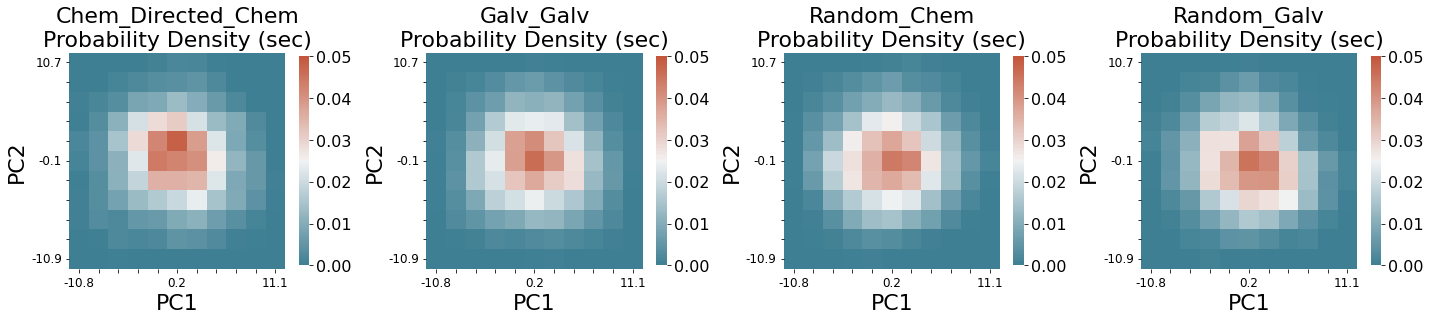

In [17]:
########### PLOT THE DISTRIBUTIONS OF THE SEPARATED MIGRATION MODES #############



fig, axes = plt.subplots(1,len(transdf_expsep.Migration_Mode.unique()),figsize=(20,10))
for i, ax in enumerate(axes):
    mm = transdf_expsep.Migration_Mode.unique()[i]
    mdf = transdf_expsep[transdf_expsep.Migration_Mode==mm]
    ttot = mdf.time_elapsed.sum()
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.time_elapsed.sum()/ttot

    #plot heatmap with seaborn
#     fig, ax = plt.subplots(figsize=(nbins//2,nbins//2))
    sns.heatmap(
        bighm,
        vmin=0, vmax=0.05, #center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar_kws={'shrink': 0.3}
    )
    ax.set_xticklabels(
        [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
        fontsize = 12
    )
    ax.set_yticklabels(
        [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
        rotation=0,
        fontsize = 12
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 22)
    ax.set_ylabel('PC2', fontsize = 22)
    # adjust colorbar tick label size
    cbar = ax.collections[0].colorbar
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(f'{mm}\nProbability Density (sec)', fontsize = 22)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 probability density heatmap expseparated.png', bbox_inches='tight')

In [16]:
#### get current field for this bootstrap realization ######
####### this is for looking at data spread for the current field ############
bsfield = []
for m, mig in bsframe_expsep.groupby('Migration_Mode'):
    for x in range(nbins):
        for y in range(nbins):
            current = mig[(mig['x'] == x+1) & (mig['y'] == y+1)]
            cov = np.cov(np.array([[-current.x_minus_rate.values[0]/2, current.x_plus_rate.values[0]/2,0,0],
                    [0,0,-current.y_minus_rate.values[0]/2, current.y_plus_rate.values[0]/2]]))
            evals, evecs = np.linalg.eigh(cov)
            bsfield.append({'x':x+1,
                            'y':y+1,
                            'eval1':evals[1],
                            'eval2':evals[0],
                           'evec1x':evecs[0,1],
                           'evec1y':evecs[1,1],
                           'evec2x':evecs[0,0],
                           'evec2y':evecs[1,0],
                          'Migration_Mode':m})
        
bsfield_expsep = pd.DataFrame(bsfield)

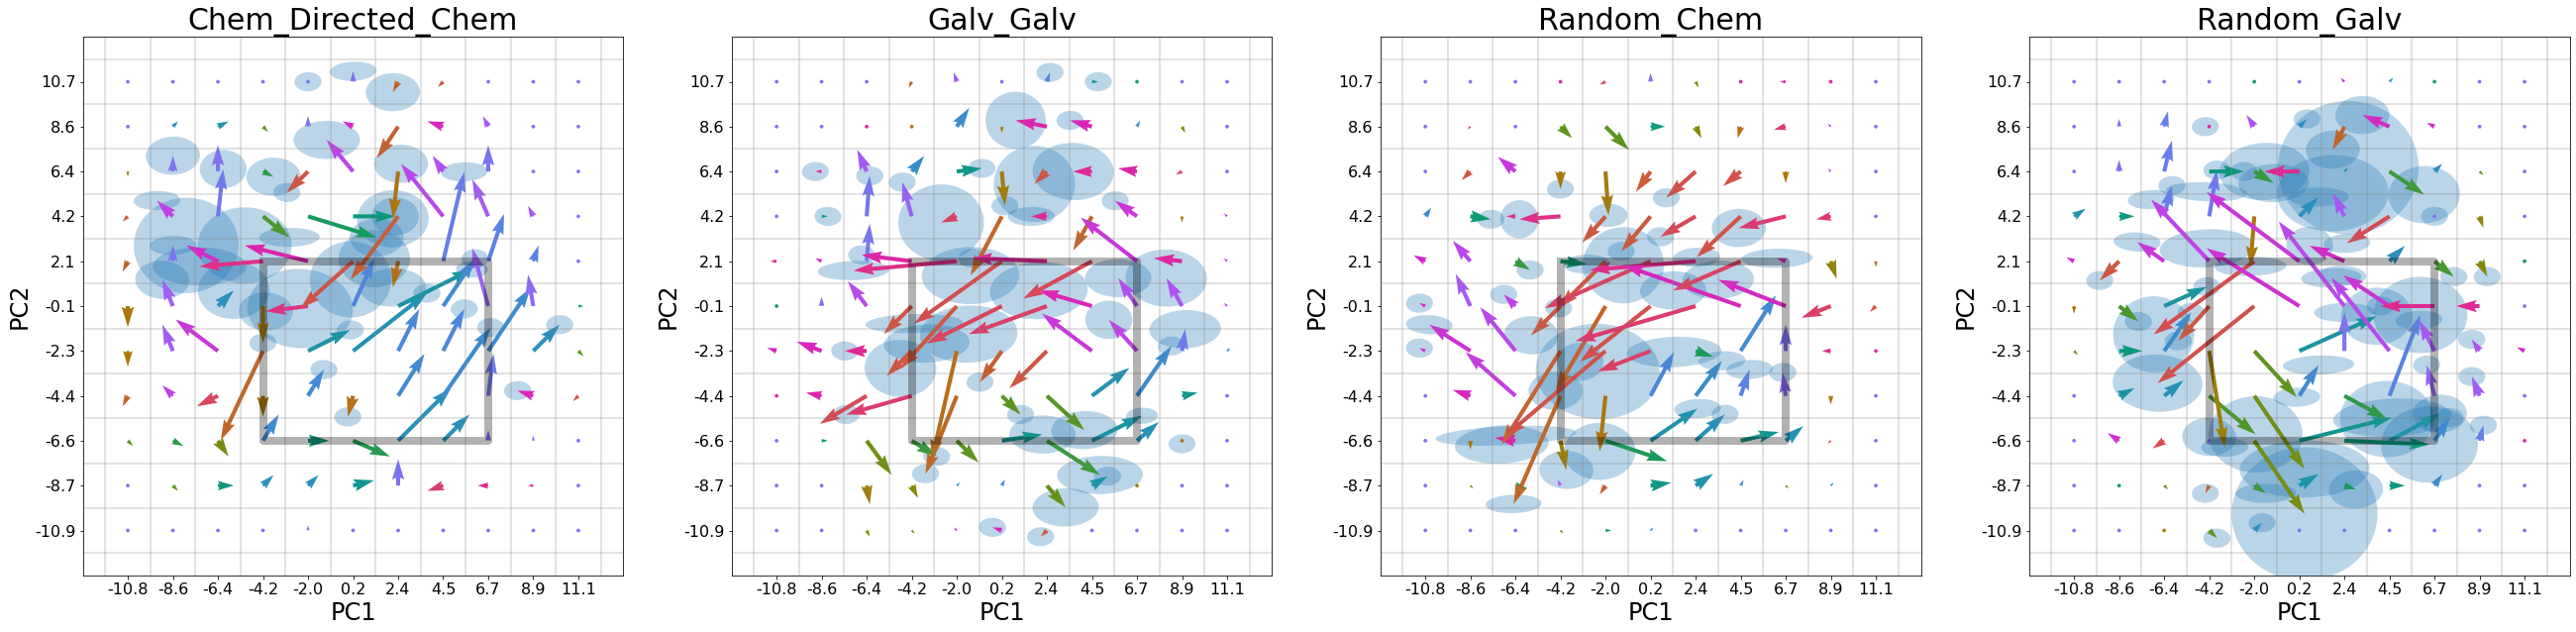

In [34]:
############## plot vectors of PC1/2 transitions from different migration modes #################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from CustomFunctions.DetailedBalance import contour_coords
# inverse scale for arrows
scale = 0.0004


# combine error data with real transition data
elldf = bsfield_expsep.merge(trans_rate_df_expsep,left_on = ['x','y','Migration_Mode'], right_on = ['x','y','Migration_Mode'])


#do color scales stuff
norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})

#subplots
fig, axes = plt.subplots(1,len(elldf.Migration_Mode.unique()),figsize=(45,10))
for i, ax in enumerate(axes):
    mm = elldf.Migration_Mode.unique()[i]
    mdf = elldf[elldf.Migration_Mode==mm]
    #add "grid lines" first 
    for h in np.linspace(0.5, nbins+0.5, nbins+1):
        ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
        ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

    #add contou line if desired
    uple = [4,7]
    lori = [9,3]
    contourcoords = contour_coords(uple,lori)
    #actually plot the contour
    ax.plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='black',alpha=0.3)

        
    for x in range(1,nbins+1):
        for y in range(1,nbins+1):
            current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
            xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
            ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

            ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                    width=np.sqrt(abs(current.eval1))*(1/scale)*2,
                      height=np.sqrt(abs(current.eval2))*(1/scale)*2,
                    angle=np.arctan2(current.evec1y,current.evec1x))
            ax.add_artist(ell)
            ell.set_alpha(0.3)

    for x in range(1,nbins+1):
        for y in range(1,nbins+1):
            current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
            xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
            ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
            anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
            ax.quiver(x,
                       y, 
                       xcurrent,
                       ycurrent,
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = scale,
                      color = cmm(norm(anglecolor)))


    #         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
    ax.set_xlabel('PC1', fontsize = 24)
    ax.set_ylabel('PC2', fontsize = 24)
    ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 16)
    ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
    ax.set_xlim(0,nbins+1)
    ax.set_ylim(0,nbins+1)
    ax.set_title(mm, fontsize = 30)

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)


plt.savefig(savedir + 'PC1_PC2 Vector map absolute angle colored expseparated contour.png', bbox_inches='tight')


In [32]:
######### do contour integrals for all migration modes ################
import itertools
from CustomFunctions.DetailedBalance import contour_integral
#upper left position of contour box
uple = [4,7]
#lower right position of contour box
lori = [9,3]

omega_results = []

for i, m in bsframe_expsep_full.groupby('Migration_Mode'):
    omegas = []
    iters = [[x]*(nbins**2) for x in range(int(len(m)/(nbins**2)))]#, len(migboot)
    m['bs_iteration'] = list(itertools.chain.from_iterable(iters))
    for l, b in m.groupby('bs_iteration'):
        omegas.append(contour_integral(b, uple, lori,))
    omega_results.append([i,omegas])
omegaframe = pd.DataFrame([o[1] for o in omega_results], index = [o[0] for o in omega_results])

F value: 45.322545939098106, p value: 3.5456632976677766e-29
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  -1.0046   -0.0 -1.2353 -0.7739   True
Chem_Directed_Chem Random_Chem  -0.5963    0.0  -0.827 -0.3656   True
Chem_Directed_Chem Random_Galv  -0.3095 0.0032 -0.5402 -0.0788   True
         Galv_Galv Random_Chem   0.4083    0.0  0.1776   0.639   True
         Galv_Galv Random_Galv    0.695   -0.0  0.4644  0.9257   True
       Random_Chem Random_Galv   0.2868 0.0077  0.0561  0.5175   True
---------------------------------------------------------------------


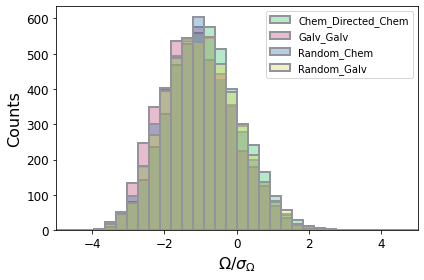

In [33]:
################ histograms of the contour integral distributions ###########

#get bins so that the widths between all types are the same
binwidth = 0.3
maxx = max([max(x[1]) for x in omega_results])+binwidth
minn = min([min(x[1]) for x in omega_results])-binwidth
binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))

#make a list of pretty colors
colorlist = [(46/255, 191/255, 104/255, 0.35),
            (189/255, 68/255, 114/255, 0.35),
            (50/255, 119/255, 168/255, 0.35),
            (217/255, 217/255, 76/255, 0.35)]
#plot the histograms
for i, o in enumerate(omega_results):
    label = bsframe_expsep_full.Migration_Mode.unique()[i]
    plt.hist(o[1]/np.std(o[1]), bins = binss, edgecolor=(146/255, 147/255, 156/255),lw=2, fc=colorlist[i], label=label)


plt.ylabel('Counts', fontsize = 16)
plt.xlabel('$Ω/σ_{Ω}$', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim(-5,5)
plt.legend()
plt.tight_layout()
plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori}.png', bbox_inches='tight')


import scipy.stats as ss


f_val, p_val = ss.f_oneway(*[o[1] for o in omega_results])
print(f'F value: {f_val}, p value: {p_val}')
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(np.array([o[1] for o in omega_results]).flatten(), 
                                     np.array([[o[0]]*len(o[1]) for o in omega_results]).flatten()))


In [47]:
############### get shcoeffs for different positions around a particular 2d contour #############
from CustomFunctions.PCanimation import interpolate_contour_shapes
import pickle as pk
from scipy import interpolate
from scipy.spatial import distance
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x]].mean().to_numpy()

pca = pk.load(open(savedir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10

fourcorners = np.array([[4,7],
[4,3],
[9,3],
[9,7]])

contour_positions, loopname = interpolate_contour_shapes(fourcorners,
                               avgpcs,
                               whichpcs,
                               pca,
                               PC1bins,
                               PC2bins,
                               savedir,
                               lmax)

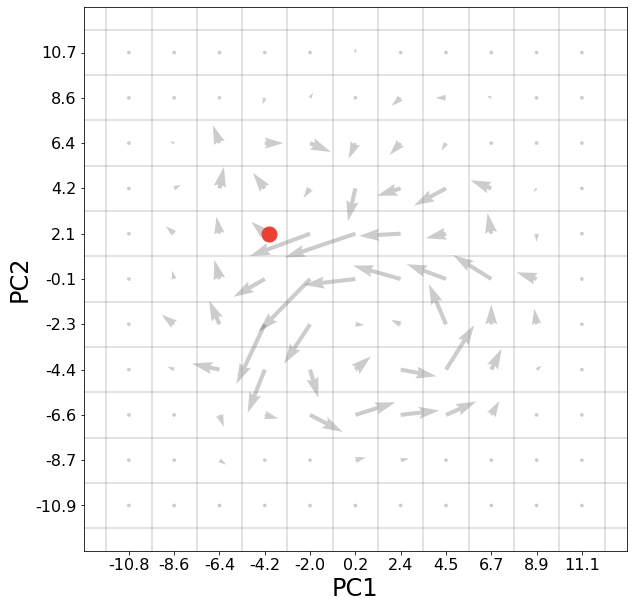

In [48]:
########## animate a contour loop graph
from matplotlib.animation import FuncAnimation 

scale = 0.0005

#make fig
fig, ax = plt.subplots(figsize = (10,10))

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

    

for x in range(nbins):
    for y in range(nbins):
        current = trans_rate_df[(trans_rate_df['x'] == x+1) & (trans_rate_df['y'] == y+1)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
#             print(anglecolor)
        ax.quiver((x+1),
                   (y+1), 
                   xcurrent, 
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = 'black',
                 alpha = 0.2)    
    
    

ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


# create a point in the axes
point, = ax.plot(contour_positions[0,1],contour_positions[0,2], marker="o", color = '#eb4034', markersize = 15)

# make function for updating point position
def animate(i, contour_positions):
    point.set_data([contour_positions[i,1]], [contour_positions[i,2]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(contour_positions))), fargs = (contour_positions,))
# plt.show()

ani.save(savedir + 'contours/' + loopname + f'/{loopname}_plotanimation_PC1-PC2.mp4', fps=30, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


In [173]:
############## get the actual bin position reconstructions for still images ##########

from CustomFunctions.PCanimation import animate_PCs

avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x]].mean().to_numpy()

pca = pk.load(open(savedir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10



fourcorners = np.array([[4,7],
[4,3],
[9,3],
[9,7]])



for x in fourcorners:
    #translate pc bins into actual pcs
    PCs = [(PC1bins[x[0]-1]+PC1bins[x[0]])/2, (PC2bins[x[1]-1]+PC2bins[x[1]])/2]

    specificdir = savedir + str(x) + '.vtp'
    animate_PCs(avgpcs, #average value for all PCs generated with the pca
            whichpcs, #which PC number is being reconstructed
            PCs, #list of PCs, [0] is the first PC, [1] is the second
            pca, #actual pca file
            specificdir,
            lmax,)